In [2]:
import aiida
from aiida import orm, load_profile
from aiida.orm import StructureData
import sys, os
from aiida.orm.utils import load_entity, load_code, load_computer, load_group, load_node
from collections import Counter
from math import pi
import numpy as np
import matplotlib.pyplot as plt
from aiida.orm import QueryBuilder
from collections import Counter
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import pandas as pd
from pandas.plotting import scatter_matrix
import ase
from ase.io import read, write
from ase.atoms import Atoms
from ase.calculators import calculator
from ase.calculators.calculator import Calculator, kpts2ndarray
from ase import Atoms
from operator import itemgetter
from ase.calculators.abinit import Abinit

# Librascal
from rascal.representations import SphericalInvariants as SOAP

sys.path.append('./kernel-tutorials/')
# Local Utilities for Notebook
from utilities.general import FPS, center_matrix, normalize_matrix, load_variables
from utilities.kernels import linear_kernel, gaussian_kernel, center_kernel
from utilities.general import load_variables, get_stats
from utilities.plotting import (
    plot_projection,
    plot_regression,
    plot_simple,
    get_cmaps,
    table_from_dict,
    check_mirrors,
)
from utilities.general import FPS, center_matrix, normalize_matrix, load_variables
from utilities.kernels import linear_kernel, gaussian_kernel, center_kernel
cmaps = get_cmaps()
plt.style.use("./kernel-tutorials/utilities/kernel_pcovr.mplstyle")
dbl_fig = (2 * plt.rcParams["figure.figsize"][0], plt.rcParams["figure.figsize"][1])

#skcosmo

from skcosmo.preprocessing import SparseKernelCenterer as SKC
import random

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler
from chemiscope import write_input
import json

In [3]:
#dataset load
len_dataset=79855
select=140
skip=100  #usually complete it is 79855
load_profile('Elena')
qb = QueryBuilder()
qb.append(orm.StructureData)
# array1 = np.random.randint(0,len_dataset, size=len_dataset)
# masked = (qb.all()[array1] > int(len_dataset-(len_dataset-select)))
# print(type(masked))
qb_red=random.sample(qb.all(), select)
# qb_red=qb.all()[::skip] #reduced dataset 
frames_ase=[]
for [structure_data] in qb_red:
    frame=structure_data.get_ase()
    frame.wrap()
    frames_ase.append(frame)

In [24]:
def frames(x):
    for [structure_data] in x:
        frame=structure_data.get_ase()
        frame.wrap(eps=1e-10)
        yield frame
def atomic_numbers(x):
    for [structure_data] in x:
        frame=structure_data.get_ase()
        mass=frame.get_atomic_numbers()
        yield mass
def natoms(x):
    for [structure_data] in x:
        natom = len(structure_data.get_site_kindnames())
        yield natom
def volumes(x):
    for [structure_data] in x:
        frame=structure_data.get_ase()
        vol=frame.get_volume()
        yield vol
 

In [25]:
# Compute SOAPs (from librascal tutorial)
soap = SOAP(soap_type='PowerSpectrum',
           interaction_cutoff=3.5,
           max_radial=6,
           max_angular=6,
           gaussian_sigma_type='Constant',
           gaussian_sigma_constant=0.4,
           cutoff_smooth_width=0.5)

soap_rep = soap.transform(frames(qb_red))


In [26]:
X_raw = soap_rep.get_features(soap)

num_features = X_raw.shape[1]
print(soap)

In [7]:
"""Initializing StandarScaler and fitting the X_raw SOAP 2D matrix so that the standard 
normal distribution of the features has a mean of zero and a standard deviation of one """

# scaler=StandardScaler()
# scaler.fit(X_raw) 
# X_scaled=scaler.transform(X_raw)
n_components = 2

# """Normal PCA, takes more memory"""

# pca=PCA(n_components=n_components) 
# pca.fit(X_scaled)
# X_pca = pca.fit_transform(X_scaled)

"""Incremental PCA, change batch size freely"""

ipca = IncrementalPCA(n_components=n_components, batch_size=10)
# ipca.fit(X_scaled)
X_ipca = ipca.fit_transform(X_raw)

In [23]:
# natoms=(list(natoms(qb_red)))



def magic(l):
    cdict={}
    for i in range(len(l)): 
        if l[i]%4==0:
            c='r'
        else:
            c='b'
        cdict['natoms='+str(l[i])]=c
    return cdict


cdict={magic}
properties = {
    "PC1": {
        "target": "atom",
        "values": X_ipca[:,0],
    },
    "PC2": {
        "target": "atom",
        "values": X_ipca[:,1],
    },
    "atomic_species": {
        "target": "atom",
        "values": np.concatenate([frame.numbers for frame in frames_ase])
    },
}

write_input("chem_mixed.json.gz", frames=frames_ase)

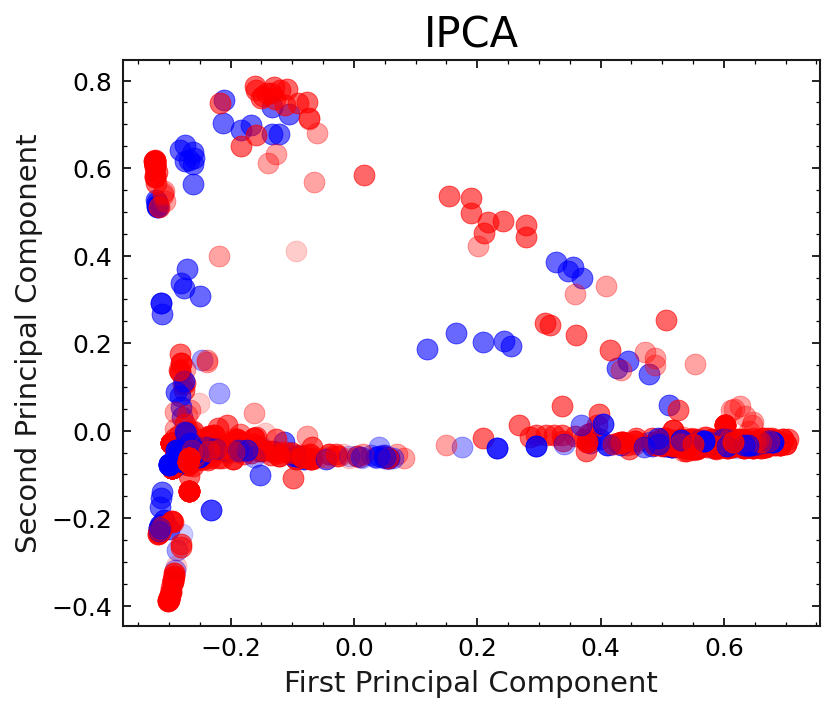

In [11]:
# ig,ax=plt.subplots(figsize=(6,5))
# start=0
# for frame in frames_ase:
#     natoms=(len(frame))
# #     print(start, natoms)
#     if natoms%4==0:
#         ax.scatter(X_pca[start:int(start+natoms), 0], X_pca[start:int(start+natoms), 1],c='r', alpha=0.2)
#     else:
#         ax.scatter(X_pca[start:int(start+natoms) , 0], X_pca[start:int(start+natoms), 1], c='b', alpha=0.2)
#     start=start+natoms
#         # plt.savefig('PCA_2.png', bbox_inches= 'tight', dpi=400 )

# plt.title("PCA",fontsize=20)
# plt.xlabel("First Principal Component",fontsize=14)
# plt.ylabel("Second Principal Component",fontsize=14)
# plt.savefig('PCA_mixed_db', bbox_inches= 'tight', dpi=700 )
# plt.show()
# plt.close()


ig,ax=plt.subplots(figsize=(6,5))
start=0
for frame in frames_ase:
    natoms=(len(frame))
#     print(start, natoms)
    if natoms%4==0:
        ax.scatter(X_ipca[start:int(start+natoms), 0], X_ipca[start:int(start+natoms), 1],c='r', alpha=0.2)
    else:
        ax.scatter(X_ipca[start:int(start+natoms) , 0], X_ipca[start:int(start+natoms), 1], c='b', alpha=0.2)
    start=start+natoms
        # plt.savefig('PCA_2.png', bbox_inches= 'tight', dpi=400 )

plt.title("IPCA",fontsize=20)
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
plt.savefig('IPCA_mixed_db', bbox_inches= 'tight', dpi=700 )
plt.show()
plt.close()

In [8]:
# len(X_ipca)
properties=['masses', 'masses']
Y = np.vstack([np.concatenate([frame.arrays[property] for frame in frames_ase]) for property in properties]).T


In [10]:
# FPS the components
print(f"Each SOAP vector contains {num_features} components.\
       \nWe use furthest point sampling to generate a subsample of our SOAP vectors.")

n_FPS=100
col_idxs, col_dist = FPS(X_raw.T, n_FPS)
X = X_raw[:, col_idxs]

Each SOAP vector contains 98784 components.       
We use furthest point sampling to generate a subsample of our SOAP vectors.


In [11]:
# Splits in train and test sets
n_train = int(len(Y)/2)
n_test = len(Y)-n_train
r_train = np.asarray(range(len(Y)))
np.random.shuffle(r_train)
i_test = list(sorted(r_train[n_train:]))
i_train = list(sorted(r_train[:n_train]))

X_train = X[i_train]
Y_train = Y[i_train]
X_test = X[i_test]
Y_test = Y[i_test]

print(f'Shape of testing data is: {X_train.shape}, ||X|| = {np.linalg.norm(X_train)}.')        

Shape of testing data is: (2386, 100), ||X|| = 34.241528622164594.


In [12]:
X_center = X_train.mean(axis=0)
Y_center = Y_train.mean(axis=0)

# Center total dataset
X = center_matrix(X, center=X_center)
Y = center_matrix(Y, center=Y_center)

# Center training data
X_train = center_matrix(X_train, center=X_center)
Y_train = center_matrix(Y_train, center=Y_center)

# Center testing data
X_test = center_matrix(X_test, center=X_center)
Y_test = center_matrix(Y_test, center=Y_center)

# Calculate the scale of the training data
X_scale = np.linalg.norm(X_train) / np.sqrt(n_train)
Y_scale = np.linalg.norm(Y_train) / np.sqrt(n_train)

# Scale the total dataset
X = normalize_matrix(X, scale=X_scale)
Y = normalize_matrix(Y, scale=Y_scale)

# Scale the training data
X_train = normalize_matrix(X_train, scale=X_scale)
Y_train = normalize_matrix(Y_train, scale=Y_scale)

# Scale the testing data
X_test = normalize_matrix(X_test, scale=X_scale)
Y_test = normalize_matrix(Y_test, scale=Y_scale)

In [13]:
K_train = gaussian_kernel(X_train, X_train)
K_train = center_kernel(K_train)

K_test = gaussian_kernel(X_test, X_train)
K_test = center_kernel(K_test)

In [14]:
C = X_train.T @ X_train

v_C, U_C = np.linalg.eigh(C)

# U_C/v_C are already sorted, but in *increasing* order, so reverse them
U_C = np.flip(U_C, axis=1)
v_C = np.flip(v_C, axis=0)

Text(0, 0.5, '$v_n$')

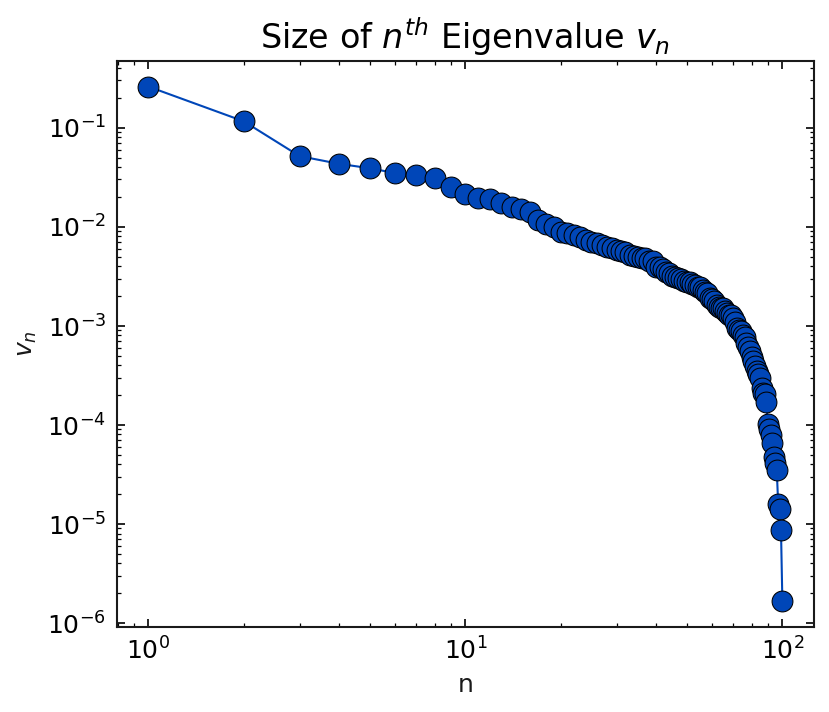

In [15]:
plt.loglog(np.asarray(range(len(v_C))) + 1, v_C / n_train, marker="o")
plt.title(r"Size of $n^{th}$ Eigenvalue $v_n$")
plt.xlabel("n")
plt.ylabel(r"$v_n$")

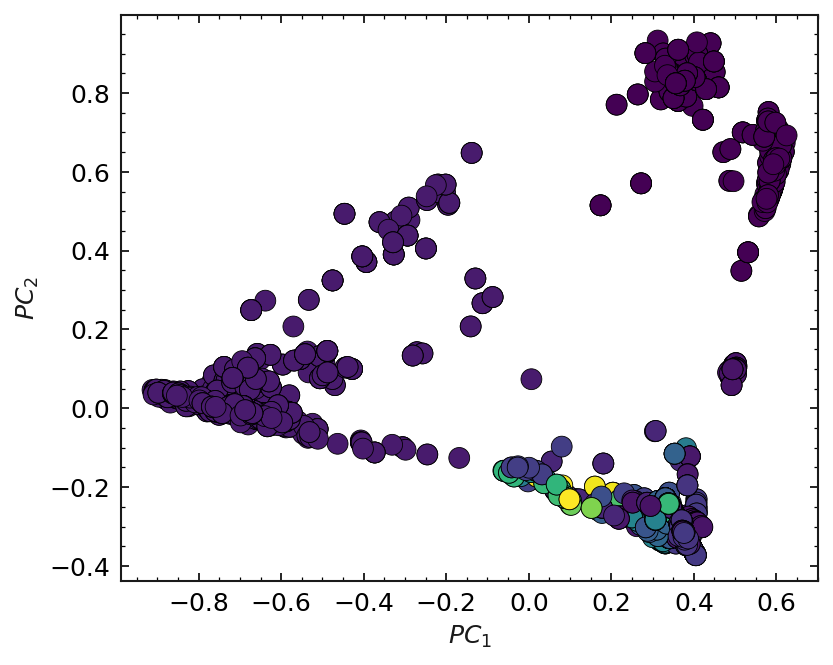

In [20]:
n_PC=100
PXT = U_C[:, :n_PC]
PTX = PXT.T

T = X_train @ PXT

plot_projection(Y_train, T, **cmaps)
plt.savefig('PCA_tutorial.png', bbox_inches= 'tight', dpi=700)

<AxesSubplot:xlabel='$PC_1$', ylabel='$PC_2$'>

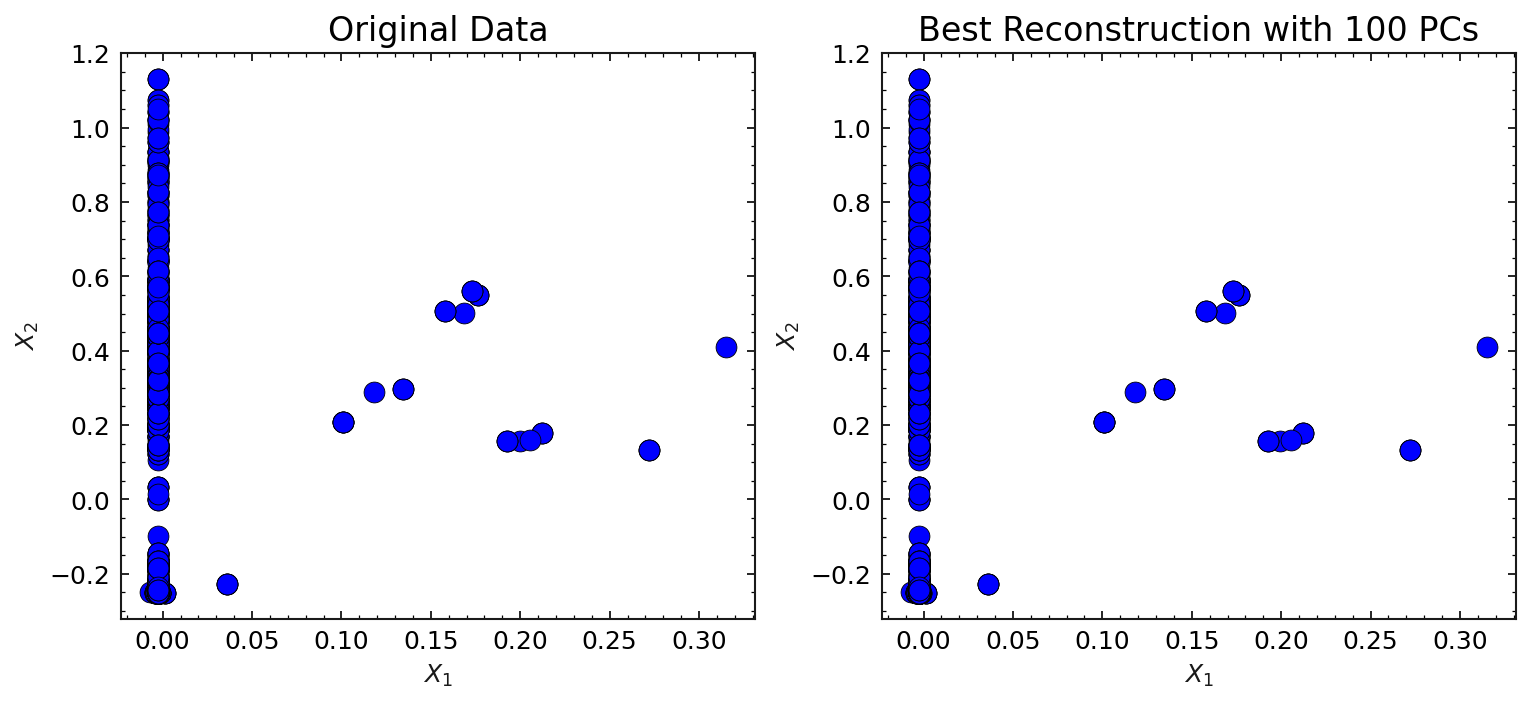

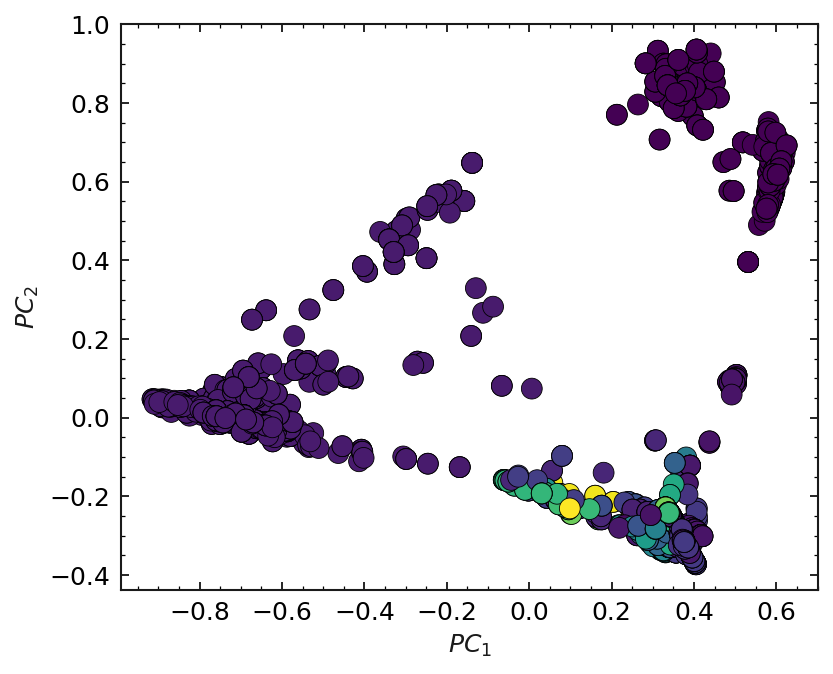

In [17]:
X_PCA = T @ PTX
fig, ax = plt.subplots(1, 2, figsize=dbl_fig)
plot_simple(X_train, fig=fig, ax=ax[0], title="Original Data", **cmaps)
plot_simple(
    X_PCA,
    fig=fig,
    ax=ax[1],
    title="Best Reconstruction with {} PCs".format(n_PC),
    **cmaps
)
T_PCA_test = X_test @ PXT
X_test_PCA = T_PCA_test @ PTX
plot_projection(Y_test, T_PCA_test, **cmaps)

In [18]:
table_from_dict([get_stats(x=X_train, y=Y_train, t=T, xr=X_PCA), 
                 get_stats(x=X_test, y=Y_test, t=T_PCA_test, xr=X_test_PCA)], 
                 headers = ["Training", "Testing"], 
                 title="PCA")

<center><b> PCA </b></center><br>                            <center><table><tr><th></th><th><center>Training</center></th><th><center>Testing</center></th></tr><td> Dataset Variance<br>$\sigma_X^2$ </td>                                                <td> 1 </td><td> 0.997499 </td></tr><tr><td> Projection Variance<br>$\sigma_T^2$ </td>                                                <td> 1 </td><td> 0.997499 </td></tr><tr><td> Residual Variance<br>$\sigma_X^2 - \sigma_T^2$ </td>                                                <td> -1.55431e-15 </td><td> -3.55271e-15 </td></tr><tr><td> $\ell_{proj}$ </td>                                                <td> 2.35338e-30 </td><td> 2.38102e-30 </td></tr></table></center>

Text(0, 0.5, 'Error')

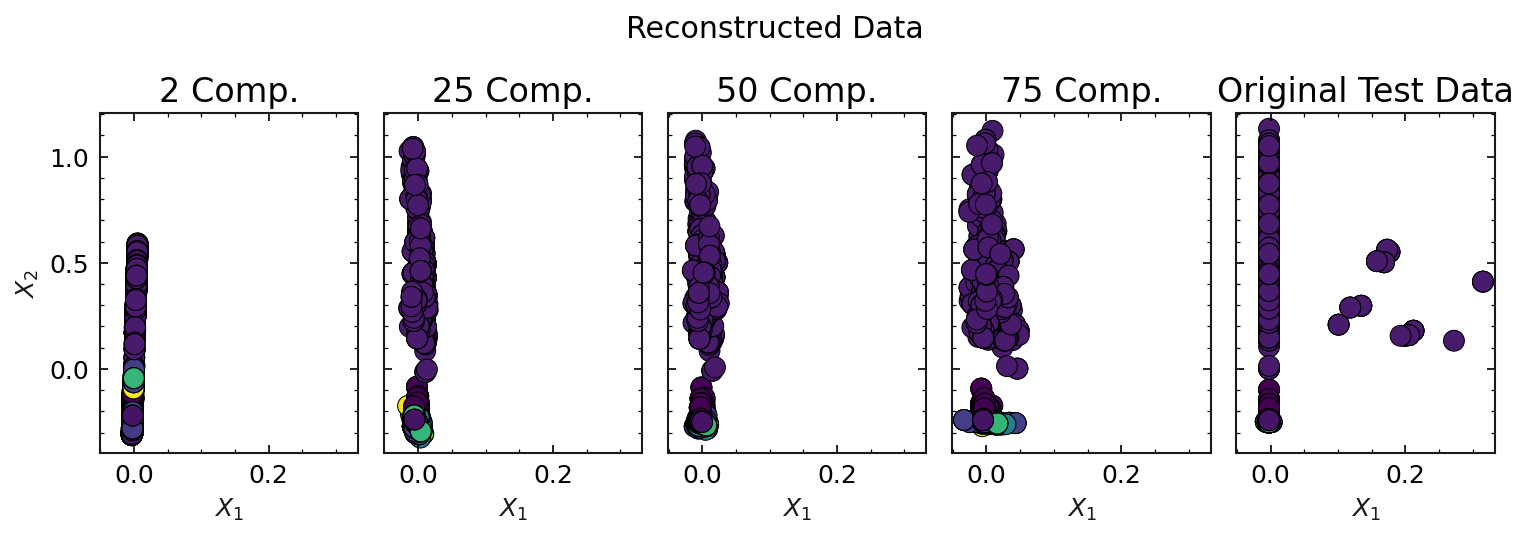

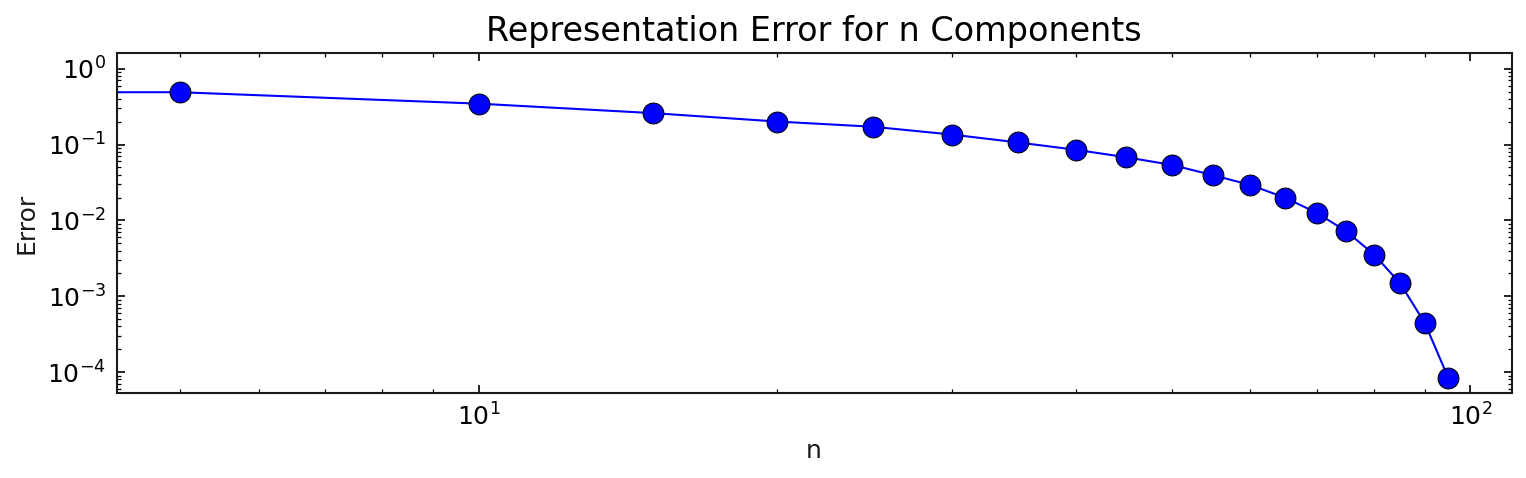

In [19]:
trials = range(X_test.shape[1])[::5]

n_plot = 4
fsize = (3 * n_plot, 3)

fig, ax = plt.subplots(1, n_plot + 1, figsize=fsize, sharex=True, sharey=True)

for i, n in enumerate(trials[:: int(len(trials) / n_plot)]):
    n = max(n, 2)
    PXT = U_C[:, :n]
    PTX = PXT.T

    X_r = X_test @ PXT @ PTX

    ax[i].scatter(X_r[:, 0], X_r[:, 1], c=Y_test[:, 0], linewidth=0.5, edgecolor="k")
    ax[i].set_title(f"{n} Comp.")
    ax[i].set_xlabel(r"$X_1$")

ax[-1].scatter(X_test[:, 0], X_test[:, 1], c=Y_test[:, 0], linewidth=0.5, edgecolor="k")
ax[-1].set_title("Original Test Data")
ax[-1].set_xlabel(r"$X_1$")
ax[0].set_ylabel(r"$X_2$")

fig.suptitle("Reconstructed Data", y=1.1)
fig.subplots_adjust(wspace=0.1)

plt.figure(figsize=fsize)
plt.loglog(
    trials,
    [
        ((X_test - X_test @ U_C[:, 0:n] @ U_C[:, :n].T) ** 2).mean(axis=0).sum()
        for n in trials
    ],
    "b-",
    marker="o",
)
plt.title(r"Representation Error for n Components")
plt.xlabel("n")
plt.ylabel("Error")